In [6]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1EPLgq999grbKX29ovLURBQ_YTnLOeFrD')

# This Book does not exist !

Using a GAN I try to create Book covers which doesnot exist in real. This project is inspired from other similar projects on https://thisxdoesnotexist.com/

In [7]:
project_name = 'this-book-does-not-exist'

In [8]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
 
# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

## Downloading and Exploring the Data

We can use the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/splcher/animefacedataset) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle.  Follow these steps to find your API credentials:

1. Sign in to  [https://kaggle.com/](https://kaggle.com),  then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file `kaggle.json` with the following contents:

```
{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
```

3. When you run `opendatsets.download`, you will be asked to enter your username & Kaggle API, which you can get from the file downloaded in step 2.

Note that you need to download the `kaggle.json` file only once. On Google Colab, you can also upload the `kaggle.json` file using the files tab, and the credentials will be read automatically.


In [9]:
!pip install opendatasets --upgrade --quiet

In [10]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/lukaanicin/book-covers-dataset'
od.download(dataset_url)

  4%|▍         | 11.0M/275M [00:00<00:02, 107MB/s]

100%|██████████| 275M/275M [00:01<00:00, 165MB/s]


In [11]:
!mkdir book-covers
!mkdir book-covers/images

In [12]:
# Copying all the images to a single folder

import shutil
import os

root_dir = './book-covers-dataset'
TargetFolder = './book-covers/images'
i = 0
for root, dirs, files in os.walk((os.path.normpath(root_dir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                # print "Found"
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder+"/{}.jpg".format(i)) #copies .jpg to new folder
                i+=1

In [13]:
DATA_DIR = './book-covers'
print(os.listdir(DATA_DIR))

['images']


In [14]:
print(os.listdir(DATA_DIR+'/images')[:10])

['4877.jpg', '12928.jpg', '5754.jpg', '7379.jpg', '3402.jpg', '15880.jpg', '374.jpg', '1103.jpg', '5034.jpg', '1895.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [15]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [16]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [17]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [18]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [20]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    for images, _ in dl:
        show_images(images, nmax)
        break

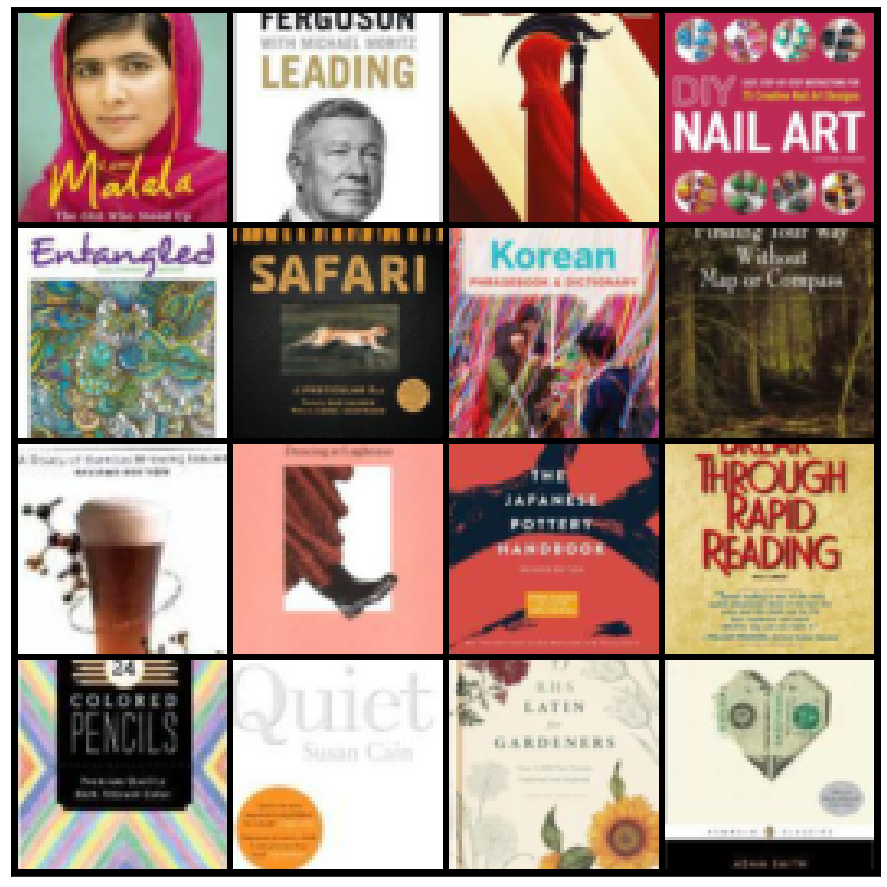

In [21]:
show_batch(train_dl)

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)

In [25]:
import torch.nn as nn

In [26]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [27]:
discriminator = to_device(discriminator, device)

In [28]:
latent_size = 128

In [29]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


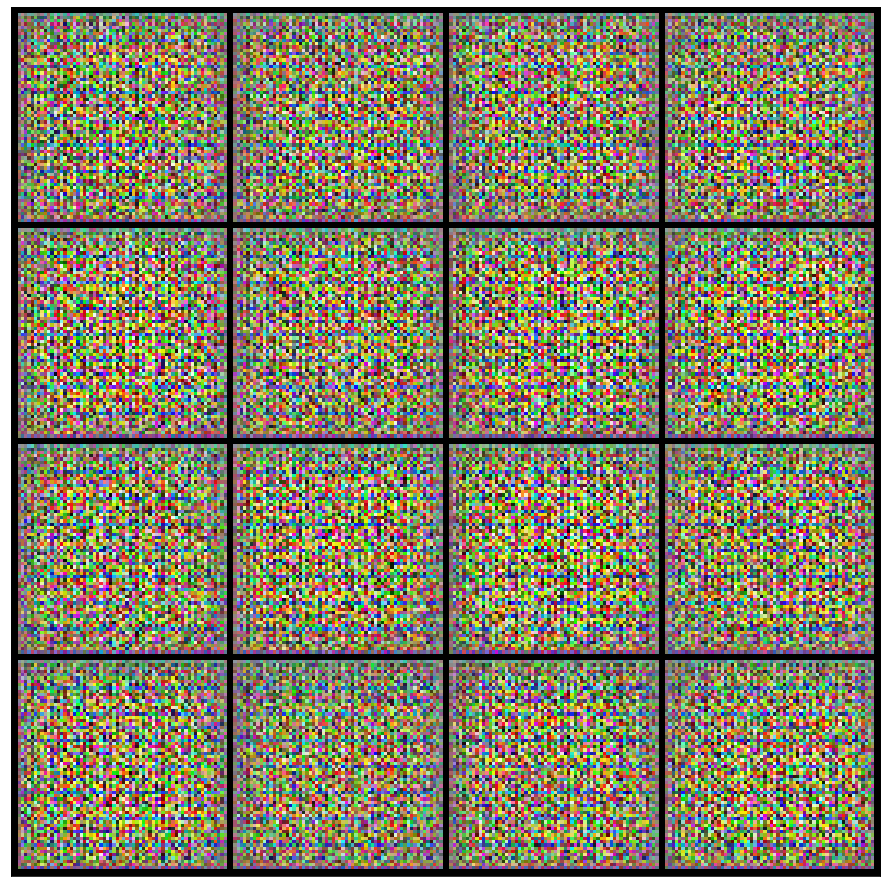

In [30]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [31]:
generator = to_device(generator, device)

In [32]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [33]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [34]:
from torchvision.utils import save_image

In [35]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [36]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=4)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))

In [37]:
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


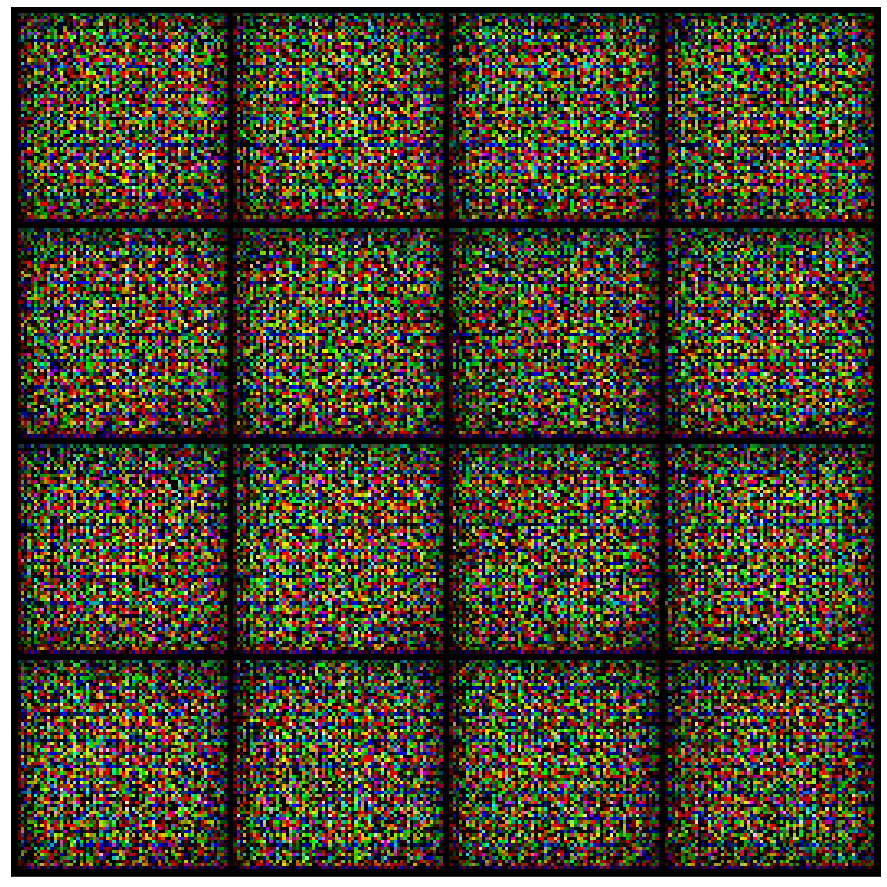

In [38]:
save_samples(0, fixed_latent)

In [39]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [40]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [41]:
lr = 0.0002
epochs = 75

In [42]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [43]:
history = fit(epochs, lr)


Epoch [1/75], loss_g: 3.2425, loss_d: 0.5460, real_score: 0.8052, fake_score: 0.2263
Saving generated-images-0001.png



Epoch [2/75], loss_g: 2.8040, loss_d: 0.5219, real_score: 0.7514, fake_score: 0.1684
Saving generated-images-0002.png



Epoch [3/75], loss_g: 2.8560, loss_d: 0.5440, real_score: 0.6808, fake_score: 0.1024
Saving generated-images-0003.png



Epoch [4/75], loss_g: 3.2823, loss_d: 0.1532, real_score: 0.8952, fake_score: 0.0273
Saving generated-images-0004.png



Epoch [5/75], loss_g: 2.9846, loss_d: 0.6216, real_score: 0.6730, fake_score: 0.1419
Saving generated-images-0005.png



Epoch [6/75], loss_g: 4.0816, loss_d: 0.5944, real_score: 0.6361, fake_score: 0.0370
Saving generated-images-0006.png



Epoch [7/75], loss_g: 4.9512, loss_d: 0.5429, real_score: 0.8887, fake_score: 0.3141
Saving generated-images-0007.png



Epoch [8/75], loss_g: 4.1900, loss_d: 0.5769, real_score: 0.6141, fake_score: 0.0129
Saving generated-images-0008.png



Epoch [9/75], loss_g: 3.7720, loss_d: 0.3096, real_score: 0.7835, fake_score: 0.0447
Saving generated-images-0009.png



Epoch [10/75], loss_g: 3.0182, loss_d: 0.3684, real_score: 0.8108, fake_score: 0.1225
Saving generated-images-0010.png



Epoch [11/75], loss_g: 6.0810, loss_d: 0.3428, real_score: 0.9838, fake_score: 0.2507
Saving generated-images-0011.png



Epoch [12/75], loss_g: 3.8271, loss_d: 0.2049, real_score: 0.8788, fake_score: 0.0589
Saving generated-images-0012.png



Epoch [13/75], loss_g: 5.5843, loss_d: 0.3481, real_score: 0.9527, fake_score: 0.2330
Saving generated-images-0013.png



Epoch [14/75], loss_g: 3.8604, loss_d: 0.3643, real_score: 0.8370, fake_score: 0.1484
Saving generated-images-0014.png



Epoch [15/75], loss_g: 2.9529, loss_d: 0.2667, real_score: 0.8910, fake_score: 0.1263
Saving generated-images-0015.png



Epoch [16/75], loss_g: 4.1093, loss_d: 0.2033, real_score: 0.9390, fake_score: 0.1145
Saving generated-images-0016.png



Epoch [17/75], loss_g: 3.0117, loss_d: 0.2219, real_score: 0.8966, fake_score: 0.0946
Saving generated-images-0017.png



Epoch [18/75], loss_g: 3.9468, loss_d: 0.2294, real_score: 0.9304, fake_score: 0.1319
Saving generated-images-0018.png



Epoch [19/75], loss_g: 6.3409, loss_d: 0.4546, real_score: 0.9973, fake_score: 0.3214
Saving generated-images-0019.png



Epoch [20/75], loss_g: 3.4142, loss_d: 0.1295, real_score: 0.9528, fake_score: 0.0706
Saving generated-images-0020.png



Epoch [21/75], loss_g: 5.8834, loss_d: 0.0770, real_score: 0.9723, fake_score: 0.0454
Saving generated-images-0021.png



Epoch [22/75], loss_g: 3.2870, loss_d: 0.1570, real_score: 0.8876, fake_score: 0.0238
Saving generated-images-0022.png



Epoch [23/75], loss_g: 4.6286, loss_d: 0.1253, real_score: 0.9784, fake_score: 0.0936
Saving generated-images-0023.png



Epoch [24/75], loss_g: 11.3540, loss_d: 2.1500, real_score: 0.9997, fake_score: 0.8221
Saving generated-images-0024.png



Epoch [25/75], loss_g: 4.8884, loss_d: 0.1107, real_score: 0.9891, fake_score: 0.0904
Saving generated-images-0025.png



Epoch [26/75], loss_g: 4.1815, loss_d: 0.1492, real_score: 0.9917, fake_score: 0.1185
Saving generated-images-0026.png



Epoch [27/75], loss_g: 5.0644, loss_d: 0.3021, real_score: 0.7811, fake_score: 0.0080
Saving generated-images-0027.png



Epoch [28/75], loss_g: 4.3080, loss_d: 0.0854, real_score: 0.9521, fake_score: 0.0304
Saving generated-images-0028.png



Epoch [29/75], loss_g: 4.4010, loss_d: 0.0796, real_score: 0.9605, fake_score: 0.0359
Saving generated-images-0029.png



Epoch [30/75], loss_g: 3.0797, loss_d: 0.1739, real_score: 0.8665, fake_score: 0.0138
Saving generated-images-0030.png



Epoch [31/75], loss_g: 5.3614, loss_d: 0.0489, real_score: 0.9879, fake_score: 0.0352
Saving generated-images-0031.png



Epoch [32/75], loss_g: 0.2739, loss_d: 3.6625, real_score: 0.0854, fake_score: 0.0010
Saving generated-images-0032.png



Epoch [33/75], loss_g: 6.1877, loss_d: 0.0876, real_score: 0.9278, fake_score: 0.0067
Saving generated-images-0033.png



Epoch [34/75], loss_g: 5.2528, loss_d: 0.0173, real_score: 0.9939, fake_score: 0.0110
Saving generated-images-0034.png



Epoch [35/75], loss_g: 4.2093, loss_d: 0.1877, real_score: 0.8617, fake_score: 0.0262
Saving generated-images-0035.png



Epoch [36/75], loss_g: 4.2939, loss_d: 0.1131, real_score: 0.9501, fake_score: 0.0557
Saving generated-images-0036.png



Epoch [37/75], loss_g: 2.9199, loss_d: 0.3478, real_score: 0.8213, fake_score: 0.1162
Saving generated-images-0037.png



Epoch [38/75], loss_g: 0.5256, loss_d: 0.2883, real_score: 0.7829, fake_score: 0.0157
Saving generated-images-0038.png



Epoch [39/75], loss_g: 6.0544, loss_d: 0.2496, real_score: 0.9925, fake_score: 0.1921
Saving generated-images-0039.png



Epoch [40/75], loss_g: 2.6779, loss_d: 0.1443, real_score: 0.9242, fake_score: 0.0554
Saving generated-images-0040.png



Epoch [41/75], loss_g: 2.9935, loss_d: 0.4453, real_score: 0.6986, fake_score: 0.0058
Saving generated-images-0041.png



Epoch [42/75], loss_g: 5.4349, loss_d: 0.0684, real_score: 0.9795, fake_score: 0.0448
Saving generated-images-0042.png



Epoch [43/75], loss_g: 8.6184, loss_d: 0.1014, real_score: 0.9151, fake_score: 0.0019
Saving generated-images-0043.png



Epoch [44/75], loss_g: 4.3362, loss_d: 0.0797, real_score: 0.9747, fake_score: 0.0492
Saving generated-images-0044.png



Epoch [45/75], loss_g: 4.4175, loss_d: 0.0857, real_score: 0.9826, fake_score: 0.0625
Saving generated-images-0045.png



Epoch [46/75], loss_g: 4.9121, loss_d: 0.1419, real_score: 0.9801, fake_score: 0.1051
Saving generated-images-0046.png



Epoch [47/75], loss_g: 5.4920, loss_d: 0.2415, real_score: 0.9828, fake_score: 0.1834
Saving generated-images-0047.png



Epoch [48/75], loss_g: 4.9841, loss_d: 0.0295, real_score: 0.9894, fake_score: 0.0183
Saving generated-images-0048.png



Epoch [49/75], loss_g: 4.8739, loss_d: 0.0283, real_score: 0.9837, fake_score: 0.0110
Saving generated-images-0049.png



Epoch [50/75], loss_g: 5.8373, loss_d: 0.2095, real_score: 0.9838, fake_score: 0.1590
Saving generated-images-0050.png



Epoch [51/75], loss_g: 4.5642, loss_d: 0.0985, real_score: 0.9727, fake_score: 0.0650
Saving generated-images-0051.png



Epoch [52/75], loss_g: 4.4611, loss_d: 0.3508, real_score: 0.7500, fake_score: 0.0164
Saving generated-images-0052.png



Epoch [53/75], loss_g: 1.7629, loss_d: 0.3300, real_score: 0.7677, fake_score: 0.0035
Saving generated-images-0053.png



Epoch [54/75], loss_g: 5.2144, loss_d: 0.0391, real_score: 0.9737, fake_score: 0.0117
Saving generated-images-0054.png



Epoch [55/75], loss_g: 4.1574, loss_d: 0.0638, real_score: 0.9763, fake_score: 0.0371
Saving generated-images-0055.png



Epoch [56/75], loss_g: 5.1106, loss_d: 0.1067, real_score: 0.9724, fake_score: 0.0721
Saving generated-images-0056.png



Epoch [57/75], loss_g: 5.2130, loss_d: 0.0617, real_score: 0.9779, fake_score: 0.0369
Saving generated-images-0057.png



Epoch [58/75], loss_g: 4.8210, loss_d: 0.0232, real_score: 0.9956, fake_score: 0.0184
Saving generated-images-0058.png



Epoch [59/75], loss_g: 4.5594, loss_d: 0.0520, real_score: 0.9809, fake_score: 0.0300
Saving generated-images-0059.png



Epoch [60/75], loss_g: 5.2272, loss_d: 0.0893, real_score: 0.9761, fake_score: 0.0592
Saving generated-images-0060.png



Epoch [61/75], loss_g: 4.6289, loss_d: 0.0942, real_score: 0.9474, fake_score: 0.0335
Saving generated-images-0061.png



Epoch [62/75], loss_g: 6.3210, loss_d: 0.0245, real_score: 0.9929, fake_score: 0.0167
Saving generated-images-0062.png



Epoch [63/75], loss_g: 5.0304, loss_d: 0.0399, real_score: 0.9954, fake_score: 0.0329
Saving generated-images-0063.png



Epoch [64/75], loss_g: 4.8186, loss_d: 0.0398, real_score: 0.9839, fake_score: 0.0227
Saving generated-images-0064.png



Epoch [65/75], loss_g: 3.2313, loss_d: 0.1544, real_score: 0.9132, fake_score: 0.0498
Saving generated-images-0065.png



Epoch [66/75], loss_g: 3.6872, loss_d: 0.0572, real_score: 0.9656, fake_score: 0.0211
Saving generated-images-0066.png



Epoch [67/75], loss_g: 2.3313, loss_d: 0.1784, real_score: 0.8591, fake_score: 0.0055
Saving generated-images-0067.png



Epoch [68/75], loss_g: 4.3838, loss_d: 0.1010, real_score: 0.9442, fake_score: 0.0370
Saving generated-images-0068.png



Epoch [69/75], loss_g: 3.8512, loss_d: 0.1340, real_score: 0.9200, fake_score: 0.0397
Saving generated-images-0069.png



Epoch [70/75], loss_g: 5.2187, loss_d: 0.0688, real_score: 0.9988, fake_score: 0.0620
Saving generated-images-0070.png



Epoch [71/75], loss_g: 5.3121, loss_d: 0.0364, real_score: 0.9780, fake_score: 0.0135
Saving generated-images-0071.png



Epoch [72/75], loss_g: 5.4309, loss_d: 0.4693, real_score: 0.7143, fake_score: 0.0180
Saving generated-images-0072.png



Epoch [73/75], loss_g: 3.9569, loss_d: 0.2017, real_score: 0.8745, fake_score: 0.0487
Saving generated-images-0073.png



Epoch [74/75], loss_g: 5.2527, loss_d: 0.0324, real_score: 0.9886, fake_score: 0.0200
Saving generated-images-0074.png



Epoch [75/75], loss_g: 1.1056, loss_d: 0.3942, real_score: 0.7417, fake_score: 0.0246
Saving generated-images-0075.png


In [44]:
losses_g, losses_d, real_scores, fake_scores = history

In [45]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [46]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [47]:
from IPython.display import Image

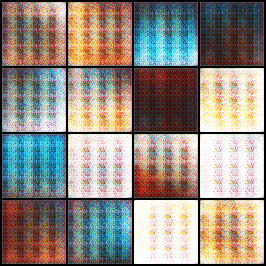

In [57]:
Image('./generated/generated-images-0001.png',width = 512,height = 512)

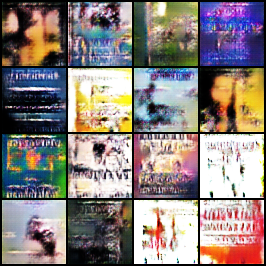

In [60]:
Image('./generated/generated-images-0020.png',width = 512,height = 512)

In [59]:
Image('./generated/generated-images-0030.png',width = 512,height = 512)

SyntaxError: ignored

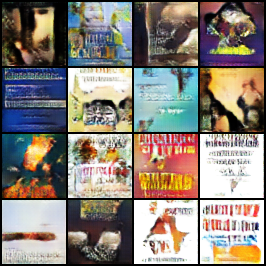

In [61]:
Image('./generated/generated-images-0050.png',width = 512,height = 512)

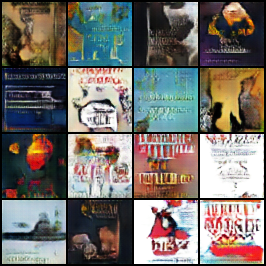

In [62]:
Image('./generated/generated-images-0075.png',width = 512,height = 512)

In [53]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

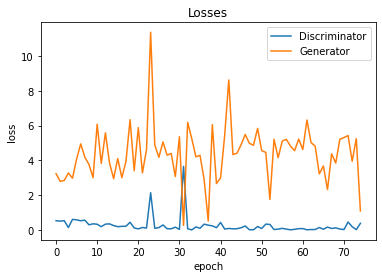

In [54]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

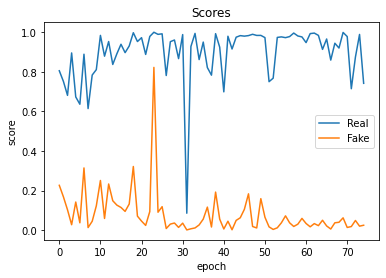

In [55]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [63]:
import jovian
jovian.commit(project=project_name, 
              outputs=['G.pth', 'D.pth', 'gans_training.avi'], 
              environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/fyse-nassar/this-book-does-not-exist


'https://jovian.ai/fyse-nassar/this-book-does-not-exist'

# Outcomes
Trained a GAN model which generates book covers which does not exist in real.

# Future Work

*   Generate images with higher resolution
*   Hyperparameter Tuning
*   Modify the model in such a way that the book title and author gets generated too.
*   Deploy the model using Streamlit library.



